### RWSE-Checker: true-positives statistics from balanced corpus

In [1]:
from rwse import RWSE_Checker
import os
import pickle
import spacy

/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rwse = RWSE_Checker()
rwse.set_confusion_sets('input/confusion_sets_modified.csv')

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

#### Load sentences by confusion sets

In [3]:
file_name = 'input/eng_news_2023-balanced-sentences.csv'

sentences_by_confusion_sets = dict()
with open(file_name, 'r') as f:
    lines = f.readlines()
    for line in lines:
        confusion_set, sentence = line.strip().split('\t')
        if sentences_by_confusion_sets.get(confusion_set) is None:
            sentences_by_confusion_sets[confusion_set] = []
        sentences_by_confusion_sets[confusion_set].append(sentence)

total = 0

for key, value in sorted(sentences_by_confusion_sets.items()):
    total += len(value)
    print(key, '=', len(value))

print('total =', total)

Being,begin,being = 100
Capital,Capitol,capital = 100
Country,County,country,county = 100
Desert,desert,dessert = 100
Easy,ease,easy = 100
Effect,affect,effect = 100
Effects,affects,effects = 100
Except,accept,except = 100
Few,View,few,view = 100
Form,From,form,from = 100
Found,Fund,found,fund = 100
Fourth,forth,fourth = 100
Hole,Whole,hole,whole = 100
Lead,Led,lead,led = 100
Life,Live,life,live = 100
Mad,Made,mad,made = 100
Or,or,ore = 94
Past,passed,past = 100
Peace,Piece,peace,piece = 100
Plain,plain,plane = 100
Principal,principal,principle = 100
Provence,Province,province = 12
Quiet,Quite,quiet,quite = 100
Rise,raise,rise = 100
Safe,Save,safe,save = 100
Site,sight,site = 100
Split,spit,split = 59
Than,Then,than,then = 100
Their,There,They,their,there,they = 100
Them,Theme,them,theme = 100
Things,things,thinks = 100
Three,Tree,three,tree = 100
To,Too,Two,to,too,two = 100
Trail,Trial,trail,trial = 100
Weather,Whether,weather,whether = 100
Week,weak,week = 100
Were,Where,were,where =

#### Switch confusion words in sentences

In [4]:
from util.helper import replace_confusion_set_words_in_sentences

file_name = 'output/falsified_eng_new_2023-balanced-sentences.pkl'

if not os.path.exists(file_name):
    nlp = spacy.load("en_core_web_sm")
    modified_sentences_by_confusion_sets = replace_confusion_set_words_in_sentences(sentences_by_confusion_sets, nlp)
    with open(file_name, 'wb') as f:
        pickle.dump(modified_sentences_by_confusion_sets, f)
else:
    modified_sentences_by_confusion_sets = pickle.load(open(file_name, 'rb'))


total = 0
for key, value in modified_sentences_by_confusion_sets.items():
    total += len(value)
    print(key, '=', len(value))

print('total =', total)

Except,accept,except = 161
advice,advise = 100
Effect,affect,effect = 134
Being,begin,being = 109
bitch,pitch = 38
brakes,breaks = 61
Capital,Capitol,capital = 108
Site,sight,site = 116
Country,County,country,county = 208
crab,crap = 59
Desert,desert,dessert = 115
Easy,ease,easy = 121
Effects,affects,effects = 127
extend,extent = 100
feat,feet = 106
Few,View,few,view = 202
Form,From,form,from = 210
Fourth,forth,fourth = 112
forms,forums = 86
Found,Fund,found,fund = 202
Lead,Led,lead,led = 208
Life,Live,life,live = 202
loose,lose = 101
Mad,Made,mad,made = 204
Or,or,ore = 101
Past,passed,past = 127
Peace,Piece,peace,piece = 208
Plain,plain,plane = 167
Principal,principal,principle = 122
Provence,Province,province = 12
Quiet,Quite,quiet,quite = 208
Rise,raise,rise = 144
Safe,Save,safe,save = 204
Split,spit,split = 65
Than,Then,than,then = 208
Their,There,They,their,there,they = 508
Them,Theme,them,theme = 216
Things,things,thinks = 109
Trail,Trial,trail,trial = 204
Three,Tree,three,tree =

#### Determine RWSEs

In [5]:
from cassis import Cas, load_typesystem
import spacy

T_SENTENCE = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence'
T_RWSE = 'de.tudarmstadt.ukp.dkpro.core.api.anomaly.type.RWSE'
T_TOKEN = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token'

nlp = spacy.load('en_core_web_sm')

path = 'input/TypeSystem.xml'

with open(path, 'rb') as f:
    ts = load_typesystem(f)

S = ts.get_type(T_SENTENCE)
T = ts.get_type(T_TOKEN)

In [6]:
file_name = 'output/false_negatives_balanced.csv'

with open(file_name, 'w') as f:

    result = dict()

    for confusion_set, box in modified_sentences_by_confusion_sets.items():
        rwse.set_confusion_sets([set(confusion_set.split(','))])
        matches = 0
        for item in box:
            cas = Cas(ts)
            sentence = item['sentence']
            # TODO clean sentence?
            cas.sofa_string = sentence
            doc = nlp(cas.sofa_string)
            cas_sentence = S(begin=0, end=len(sentence))
            cas.add(cas_sentence)
            for token in doc:
                cas_token = T(begin=token.idx, end=token.idx+len(token.text), id=token.i)
                cas.add(cas_token)
            rwse.check_cas(cas, ts)
            true_positives = cas.select(T_RWSE)
            if len(true_positives) == 0:
                before = sentence[item['new_token']['begin']:item['new_token']['end']]
                modified_string = sentence[:item['new_token']['begin']] + ' [[' + item['new_token']['word'] + ']] ' + sentence[item['new_token']['end']:]
                print(f"expected suggestion: {item['org_word']}", f"for token: {item['new_token']['word']}" , modified_string, sep='\t', file=f)
            else:
                matches += 1
        result[confusion_set] = {
            'num_sentences':len(box),
            'num_matches':matches,
        }

#### Determine Sensitivity (True-Positive-Rate)

In [7]:
total = sum(item['num_sentences'] for item in result.values())
total_matches = sum(item['num_matches'] for item in result.values())
print(f'true positive rate: {total_matches/total:.2f}')
print(f'correctly identified {total_matches} out of {total}')

true positive rate: 0.97
correctly identified 7913 out of 8173


In [8]:
file_name = 'output/report_true_positives_balanced.csv'

with open(file_name, 'w') as f:
    print('confusion_set', 'num_matches', 'num_sentences', sep=';', file=f)
    for key, value in result.items():
        print(key, value['num_matches'], value['num_sentences'], sep=';', file=f)
        print(key, value['num_matches'], value['num_sentences'], sep='\t')

Except,accept,except	161	161
advice,advise	99	100
Effect,affect,effect	127	134
Being,begin,being	109	109
bitch,pitch	37	38
brakes,breaks	56	61
Capital,Capitol,capital	102	108
Site,sight,site	110	116
Country,County,country,county	193	208
crab,crap	51	59
Desert,desert,dessert	107	115
Easy,ease,easy	118	121
Effects,affects,effects	125	127
extend,extent	100	100
feat,feet	105	106
Few,View,few,view	199	202
Form,From,form,from	210	210
Fourth,forth,fourth	111	112
forms,forums	80	86
Found,Fund,found,fund	198	202
Lead,Led,lead,led	199	208
Life,Live,life,live	187	202
loose,lose	98	101
Mad,Made,mad,made	203	204
Or,or,ore	101	101
Past,passed,past	125	127
Peace,Piece,peace,piece	199	208
Plain,plain,plane	156	167
Principal,principal,principle	116	122
Provence,Province,province	12	12
Quiet,Quite,quiet,quite	202	208
Rise,raise,rise	138	144
Safe,Save,safe,save	201	204
Split,spit,split	62	65
Than,Then,than,then	207	208
Their,There,They,their,there,they	489	508
Them,Theme,them,theme	215	216
Things,things,

<Axes: xlabel='confusion_set'>

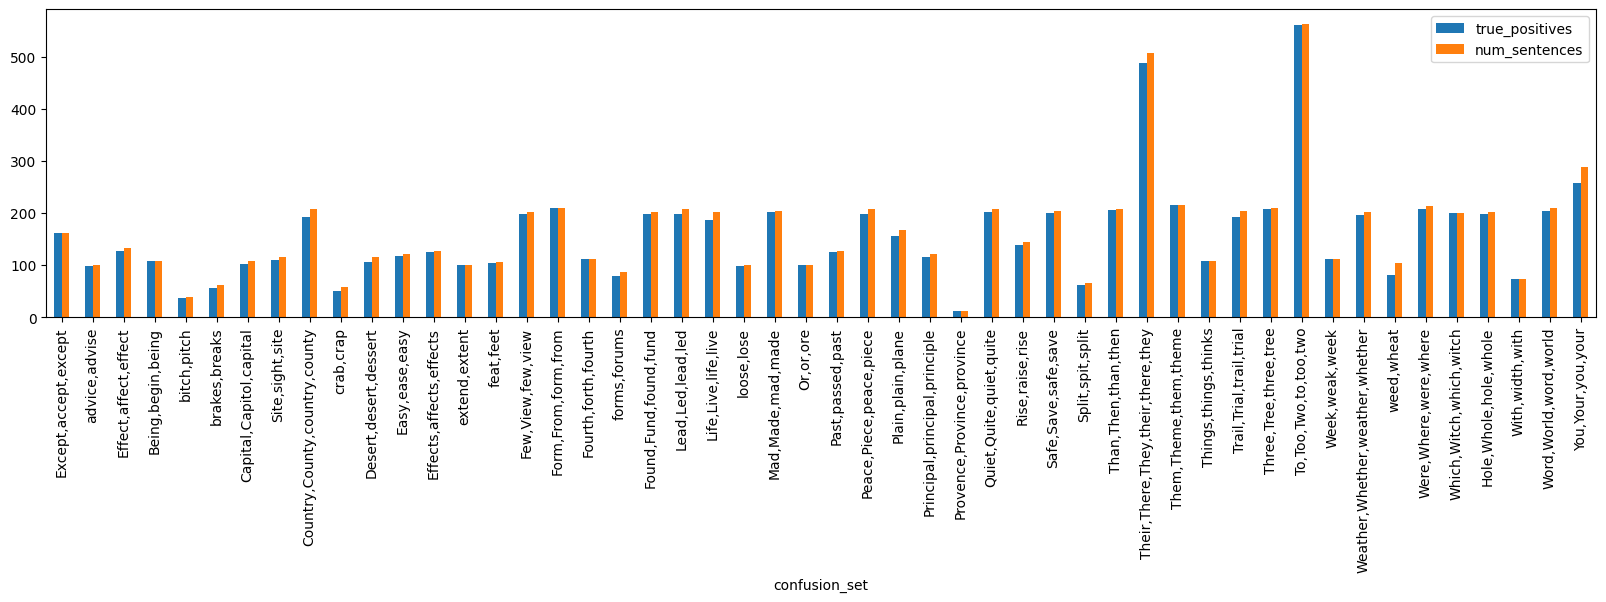

In [9]:
import pandas as pd

tp_df = pd.read_csv(file_name, sep=';')#[['confusion_set', 'num_sentences']]
tp_df.columns = ['confusion_set', 'true_positives', 'num_sentences']
tp_df.index = tp_df['confusion_set']
tp_df.plot(kind="bar", figsize=(20,4))

#### Determine Mean Sensitivity

In [10]:
data_true_positives = dict()
with open(file_name, 'r') as f:
    lines = f.readlines()
    for line in lines[1:]:
        confusion_set, num_matches, num_sequences = line.strip().split(';')
        data_true_positives[confusion_set] = (int(num_matches), int(num_sequences))

mean_sensitivity = 0
data_mean_sensitivity = dict()
for key, item in data_true_positives.items():
    if item[1] > 0:
        value = item[0]/item[1]
        print(f'{key}: {value:.10f}')
        mean_sensitivity += value
        data_mean_sensitivity[key] = value
    else:
        print(f'No data for {key}.')

mean_sensitivity /= len(data_true_positives)

print(f'Mean Sensitivity = {mean_sensitivity:.10f}')

Except,accept,except: 1.0000000000
advice,advise: 0.9900000000
Effect,affect,effect: 0.9477611940
Being,begin,being: 1.0000000000
bitch,pitch: 0.9736842105
brakes,breaks: 0.9180327869
Capital,Capitol,capital: 0.9444444444
Site,sight,site: 0.9482758621
Country,County,country,county: 0.9278846154
crab,crap: 0.8644067797
Desert,desert,dessert: 0.9304347826
Easy,ease,easy: 0.9752066116
Effects,affects,effects: 0.9842519685
extend,extent: 1.0000000000
feat,feet: 0.9905660377
Few,View,few,view: 0.9851485149
Form,From,form,from: 1.0000000000
Fourth,forth,fourth: 0.9910714286
forms,forums: 0.9302325581
Found,Fund,found,fund: 0.9801980198
Lead,Led,lead,led: 0.9567307692
Life,Live,life,live: 0.9257425743
loose,lose: 0.9702970297
Mad,Made,mad,made: 0.9950980392
Or,or,ore: 1.0000000000
Past,passed,past: 0.9842519685
Peace,Piece,peace,piece: 0.9567307692
Plain,plain,plane: 0.9341317365
Principal,principal,principle: 0.9508196721
Provence,Province,province: 1.0000000000
Quiet,Quite,quiet,quite: 0.97

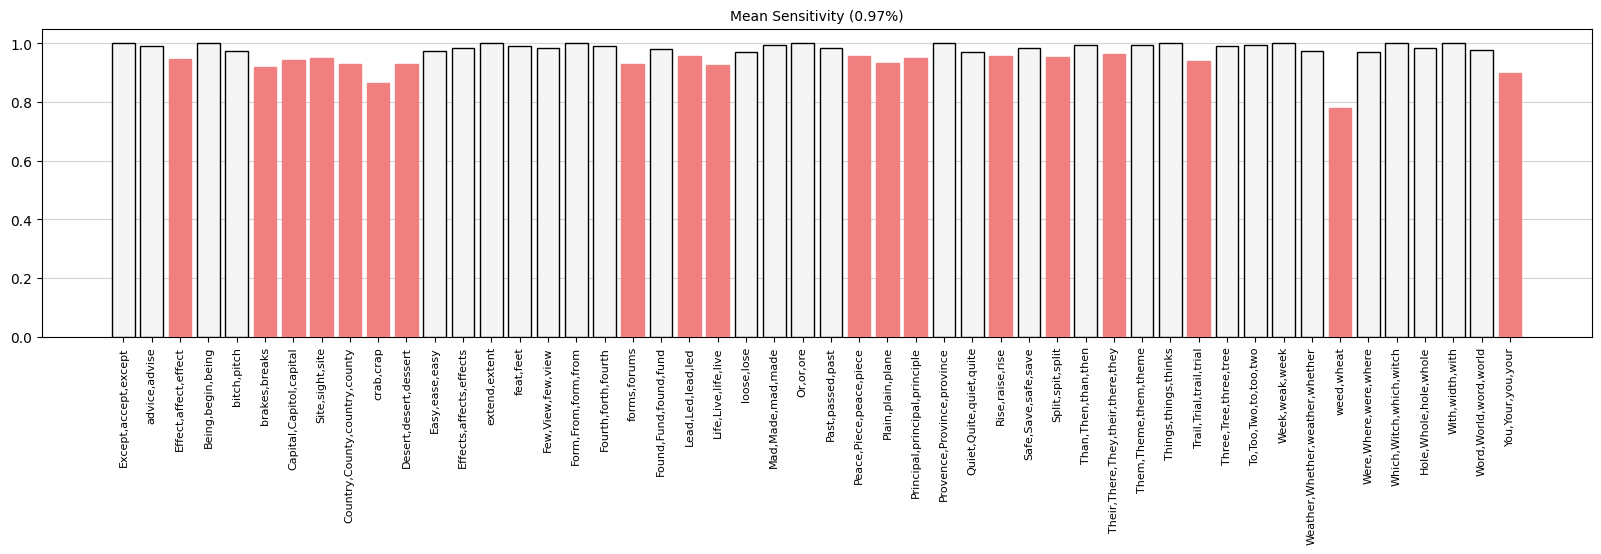

In [11]:
import matplotlib.pyplot as plt

xticks = list(range(len(data_mean_sensitivity)))
values = list(data_mean_sensitivity.values())
labels = list(data_mean_sensitivity.keys())

fig, ax = plt.subplots(figsize=(20,4))
ax.set_title(f"Mean Sensitivity ({mean_sensitivity:.2f}%)", fontsize=10)
#ax.plot(xticks, values, color="darkgrey")
bars = ax.bar(xticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value < mean_sensitivity:
        bars[idx].set_color('lightcoral')
#ax.plot(xticks,[b_tpr]*len(xticks), zorder=3, color="red", linewidth=1)
ax.set_xticks(xticks, labels, rotation='vertical')
ax.xaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)